# Function for `sum`

In [3]:
import numpy as np
from dezero import Function
from dezero import Variable

x1 = Variable(np.array(1.0))
x2 = Variable(np.array(2.0))
x3 = Variable(np.array(3.0))

y = x1 + x2 + x3
y.backward(retain_grad=True)

print(y)

Variable(6.0)


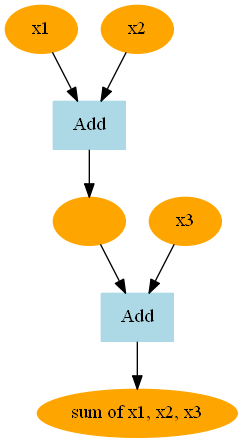

In [6]:
from dezero.utils import plot_dot_graph

x1.name = "x1"
x2.name = "x2"
x3.name = "x3"

y.name = "sum of x1, x2, x3"

plot_dot_graph(y, verbose=False, to_file='sum.png')

In [7]:
print(x1.grad, x2.grad, x3.grad)

Variable(1.0) Variable(1.0) Variable(1.0)


### `sum` just pass the gradient to the elements directly

## Implement `Sum` Function

We have to implement broadcast function for this and we will implement later

In [9]:
class Sum(Function):
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum()
        return y
    
    def backward(self, gy):
        # currently broadcast_to is not implemented!
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x):
    return Sum()(x)

So we should make the following code work later :)<br>
Right now it doesn't work!

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([1, 2, 3, 4, 5, 6]))
y = F.sum(x)
y.backward()

print(y)
print(x.grad)

And this sum function should works well even at 2-dim array

In [ ]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3],
                       [4, 5, 6]]))
y = F.sum(x)
y.backward()

print(y)
print(x.grad)

## `axis` & `keepdims`

Sum functions should work more delicated!

In [11]:
import numpy as np

x = np.array([[1, 2, 3],
              [4, 5, 6]])
y = np.sum(x, axis=0)

print(y)
print(x.shape, ' -> ', y.shape)

[5 7 9]
(2, 3)  ->  (3,)


Keep dims maintain the the dim

In [12]:
import numpy as np

x = np.array([[1, 2, 3],
              [4, 5, 6]])
y = np.sum(x, axis=0, keepdims=True)

print(y)
print(x.shape, ' -> ', y.shape)

[[5 7 9]]
(2, 3)  ->  (1, 3)


In [13]:
import numpy as np

x = np.array([[1, 2, 3],
              [4, 5, 6]])
y = np.sum(x, axis=(0, 1), keepdims=True)

print(y)
print(x.shape, ' -> ', y.shape)

[[21]]
(2, 3)  ->  (1, 1)


## Modify `Sum` Function to use `axis` and `keepdims`


We need following `reshape_sum_backward` function because numpy modify the shape
of output different from shape of input after `sum`!

**If we are using `keepdims` it doens't matter**

```python
def reshape_sum_backward(gy, x_shape, axis, keepdims):
    """Reshape gradient appropriately for dezero.functions.sum's backward.
    
    Args:
        gy (dezero.Variable): Gradient variable from the output by backprop
        x_shape (tuple): Shape used at sum function's forward.
        axis (None or int or tuple of ints): Axis used at sum function's forward.
        keepdims (bool): keepdims used at function's forward.
        
    Returns:
        dezero.Variable: Gradient variable which is reshaped appropriately
    """
    
    ndim = len(x_shape)
    tupled_axis = axis
    
    if axis is None:
        tupled_axis = None
    elif not isinstance(axis, tuple):
        tupled_axis = (axis,)
   
    # If we keep dim this is not necessary
    # But if we don't keep dim and sum with axis there is a problem
    
    -> if x shape is (2, 3, 4, 7, 5) and we sum with axis (1, 3)
       the result will shown out with shape (2, 4, 5) without keepdim
       for the backpropagation broadcast we should make this to (2, 1, 4, 1, 5)
       
    -> so when we we say axis (1, 3) is actual axis and gy.shape is (2, 4, 5)
       we use actual axis as index to put 1 at gy.shape
       
       for a in sorted(actual_axis):
           shape.insert(a, 1)
           
        make (2, 4, 5) to (2, 1, 4, 1, 5)
        
    if not (ndim == 0 or tupled_axis is None or keepdims):
        # if ndim is 3 and axis is -1 then actual axis is 2
        actual_axis = [a if a >= 0 else a + ndim for a in tupled_axis]
        
        shape = list(gy.shape)
        for a in sorted(actual_axis):
            shape.insert(a, 1)
    else:
        shape = gy.shape
        
    gy = gy.reshape(shape)
    return gy
```

In [14]:
s = [1, 2, 3]
s.insert(2, 1)
s

[1, 2, 1, 3]

In [9]:
import dezero

class Sum(Function):
    def __init__(self, axis=None, keepdims=False):
        self.axis = axis
        self.keepdims = keepdims
    
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum(axis=self.axis, keepdims=self.keepdims)
        return y
    
    def backward(self, gy):
        gy = dezero.utils.reshape_sum_backward(gy, self.x_shape, self.axis, self.keepdims)
        
        # currently broadcast_to is not implemented!
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x, axis=None, keepdims=False):
    return Sum(axis, keepdims)(x)

We will make to use `sum` function at variable directly!

```python
class Variable:
    ...
    
    def sum(self, axis=None, keepdims=False):
        return dezero.functions.sum(self, axis, keepdims)

```

## `Broadcast` function

Now it's time to implement `broadcast` :)!

- broadcast_to
- sum_to

### broadcast_to

Copy the value at x and make it to the defined shape!

In [15]:
import numpy as np

x = np.array([1, 2, 3])
y = np.broadcast_to(x, (2, 3))
print(y)

[[1 2 3]
 [1 2 3]]


**What will happen at backprop when we copy the values?**

-> `x + x = y` in this case we will give x twice the gradient!<br>
-> When we copy the value of x `n times` then gradient will flow to x `n times`

### We need `sum_to` function also to implement `broadcast_to` due to back propgation!

In [17]:
class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = np.broadcast_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        return gx

def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return BroadcastTo(shape)(x)

```python
def sum_to(x, shape):
    """Sum elements along axes to output an array of a given shape.
    
    Args:
        x (ndarray): Input array.
        shape: shape for the output array
        
    Returns:
        ndarray: Output array of the shape
    """
    ndim = len(shape)
    lead = x.ndim - ndim
    lead_axis = tuple(range(lead))
    
    ### what is going on here :)?
    -> if x shape is (1, 1, 5, 2, 7) and shape is (5, 2, 1)
        ndim = 3
        lead = 2
        lead_axis = (0, 1)

        axis = (4,)
        lead_axis + axis = (0, 1, 4)
        y = x.sum((0, 1, 4), keepdims=True)

        so the y shape is (5, 2, 1)
    
    axis = tuple([i + lead for i, sx in enumerate(shape) if sx == 1])
    y = x.sum(lead_axis + axis, keepdims=True)
    if lead > 0:
        y = y.squeeze(lead_axis)
    return y    
```

what is the value of `lead_axis + axis`?

In [28]:
tuple(range(3))

(0, 1, 2)

In [6]:
(0, 1, 2) + tuple([i + 3 for i, sx in enumerate((3, 5)) if sx == 1])

(0, 1, 2)

In [10]:
(0, 1) + tuple([i + 2 for i, sx in enumerate((3, 5, 1)) if sx == 1])

(0, 1, 4)

In [1]:
import numpy as np
from dezero.utils import sum_to

x = np.array([[1, 2, 3],
              [4, 5, 6]])
y = sum_to(x, (1, 3))
print(y)

y = sum_to(x, (2, 1))
print(y)

[[5 7 9]]
[[ 6]
 [15]]


The `lead axis` seems to indicte the following!

In [4]:
x = np.array([[[[[[[[[1, 2, 3],
                     [4, 5, 6]]]]]]]]])
y = sum_to(x, (1, 3))
print(y)

y = sum_to(x, (2, 1))
print(y)

[[5 7 9]]
[[ 6]
 [15]]


`sum_to` function usage is quite tricky.

- leading could only followed by case of [[[1, 2, 3]]] so `[1, 2, 3] the data` and `[[]] is leading`
- to sum we should indicate where to sum directly!
    - when there is (2, 3, 5)
    - we should input shape as (2, 3, 1) to sum the last axis which have shape 5!

In [1]:
import numpy as np

import dezero
from dezero import Variable
from dezero import Function
import dezero.functions as F

class SumTo(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = dezero.utils.sum_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return SumTo(shape)(x)

### `braodcast_to` and `sum_to` functions are interdependent

## Broadcast of different shapes

In [14]:
x0 = np.array([1, 2, 3])
x1 = np.array([10])

y = x0 + x1
print(y)

[11 12 13]


```python
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy
```

Our `Add` Function is not ready for broadcast!


```python
class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y

    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1
```

In [1]:
import numpy as np
from dezero import Variable

x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1

print(y)

y.backward()
print(x0.grad)
print(x1.grad)

Variable([11 12 13])
Variable([1 1 1])
Variable([3])


### We have to apply this to `Mul`, `Sub`, and `Div` also!

Same as `Add` function

```python
class Sub(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        return x0 - x1

    def backward(self, gy):
        gx0, gx1 = gy, -gy

        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1

class Mul(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        gx0 = gy * x1
        gx1 = gy * x0

        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1

class Div(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1**2)

        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1
    
```

In [2]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 - x1

print(y)

y.backward()
print(x0.grad)
print(x1.grad)

Variable([-9 -8 -7])
Variable([1 1 1])
Variable([-3])


In [5]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x1 - x0

print(y)

y.backward()
print(x0.grad)
print(x1.grad)

Variable([9 8 7])
Variable([-1 -1 -1])
Variable([3])


In [3]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 * x1

print(y)

y.backward()
print(x0.grad)
print(x1.grad)

Variable([10 20 30])
Variable([10 10 10])
Variable([6])


In [4]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 / x1

print(y)

y.backward()
print(x0.grad)
print(x1.grad)

Variable([0.1 0.2 0.3])
Variable([0.1 0.1 0.1])
Variable([-0.06])


## Test of `Sum` Function!

In [3]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([1, 2, 3, 4, 5, 6]))
y = F.sum(x)
y.backward()

print(y)
print(x.grad)

Variable(21)
Variable([1 1 1 1 1 1])


In [4]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1, 2, 3],
                       [4, 5, 6]]))
y = F.sum(x)
y.backward()

print(y)
print(x.grad)

Variable(21)
Variable([[1 1 1]
          [1 1 1]])


In [2]:
x = Variable(np.array([[1, 2, 3],
                       [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward()

print(y)
print(x.grad)

x = Variable(np.random.randn(2, 3, 4, 5))
y = x.sum(keepdims=True)
print(y.shape)

Variable([5 7 9])
Variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)
